In [11]:
# Importieren der Bibliotheken
import mlflow
import mlflow.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import ta

#.\venv\Scripts\activate

In [12]:
# mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns --host 127.0.0.1 --port 8080
# Setzen des MLflow Tracking URI und Anlegen eines neuen Experiments
mlflow.set_tracking_uri("http://127.0.0.1:8080")
mlflow.set_experiment("Bitcoin Price Movement Prediction CNN LSTM Learning Rate")

<Experiment: artifact_location='file:///C:/WWI2021/Semester 6/Machine Learning Project/mlruns/4', creation_time=1717926362013, experiment_id='4', last_update_time=1717926362013, lifecycle_stage='active', name='Bitcoin Price Movement Prediction CNN LSTM Learning Rate', tags={}>

In [13]:
data = pd.read_csv("C:\WWI2021\Semester 6\Machine Learning Project\LSTM_BTC\data\BTC-USD.csv")
#data

In [14]:
data['RSI'] = ta.momentum.RSIIndicator(data['Close']).rsi()
data['EMA20'] = ta.trend.EMAIndicator(data['Close'], window=20).ema_indicator()
data['EMA100'] = ta.trend.EMAIndicator(data['Close'], window=100).ema_indicator()
data['EMA150'] = ta.trend.EMAIndicator(data['Close'], window=150).ema_indicator()


In [15]:
# Simple Moving Average (SMA)
data['SMA50'] = ta.trend.SMAIndicator(close=data['Close'], window=50).sma_indicator()
# Momentum Indicator
data['Momentum'] = ta.momentum.ROCIndicator(close=data['Close'], window=10).roc()
# Rate of Change (ROC)
data['ROC'] = ta.momentum.ROCIndicator(close=data['Close'], window=12).roc()
# Bollinger Bands
bollinger = ta.volatility.BollingerBands(close=data['Close'], window=20, window_dev=2)
data['Bollinger_Middle'] = bollinger.bollinger_mavg()
data['Bollinger_Upper'] = bollinger.bollinger_hband()
data['Bollinger_Lower'] = bollinger.bollinger_lband()
# Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(close=data['Close'], window_slow=26, window_fast=12, window_sign=9)
data['MACD'] = macd.macd()


In [16]:
data.drop(['Date','High', 'Low', 'Adj Close', 'Volume','Open', 'EMA100', 'EMA150', 'SMA50', 'Momentum', 'ROC', 'Bollinger_Upper', 'Bollinger_Lower'], axis=1, inplace=True)
data['Previous_Close'] = data['Close'].shift(1)
data.dropna(inplace=True)

Sequenzlänge Accuracy

In [28]:
import mlflow
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

# Zielvariablen für die Vorhersage erstellen
data['Target'] = (data['Close'] <= data['Previous_Close']).astype(int)

data_clean = data
data_clean.dropna(inplace=True)
data_clean.reset_index(drop=True, inplace=True)

# Auswahl und Skalierung der relevanten Features
selected_features = ['Close', 'RSI', 'EMA20', 'Bollinger_Middle', 'MACD', 'Previous_Close']
sc = MinMaxScaler(feature_range=(0, 1))
scaled_features = sc.fit_transform(data[selected_features])

def create_sequences(features, target, seq_length):
    sequences = []
    labels = []
    for i in range(len(features) - seq_length):
        sequence = features[i:i + seq_length]
        label = target[i + seq_length]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Hyperparameter-Definition
SEQ_LENGTHS = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]  # Verschiedene Sequenzlängen
LEARNING_RATE = 0.01
EPOCHS = 30
BATCH_SIZE = 32

# Setzen des MLflow Tracking URI und Anlegen eines neuen Experiments
mlflow.set_tracking_uri("http://127.0.0.1:8080")
mlflow.set_experiment("Bitcoin Price Movement Prediction CNN LSTM Sequence Length")

for SEQ_LENGTH in SEQ_LENGTHS:
    with mlflow.start_run():
        params = {
            "learning_rate": LEARNING_RATE,
            "epochs": EPOCHS,
            "batch_size": BATCH_SIZE,
            "seq_length": SEQ_LENGTH
        }
        mlflow.log_params(params)

        # Daten vorbereiten basierend auf der aktuellen seq_length
        X, y = create_sequences(scaled_features, data['Target'].values, SEQ_LENGTH)

        # Datenaufteilung: 70% Training, 20% Validierung, 10% Test
        train_size = int(0.7 * len(X))
        val_size = int(0.2 * len(X))
        test_size = len(X) - train_size - val_size

        X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
        y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

        # Umformung der Daten für CNN-LSTM
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
        X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

        optimizer = Adam(learning_rate=LEARNING_RATE)

        # Modellarchitektur definieren
        model = Sequential()
        # Hinzufügen von CNN-Schichten
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(SEQ_LENGTH, len(selected_features))))
        model.add(MaxPooling1D(pool_size=2))
        # Hinzufügen von LSTM-Schichten
        model.add(LSTM(units=50, activation='relu', return_sequences=True))
        model.add(LSTM(units=50, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(units=1, activation='sigmoid'))

        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        # Callback to log metrics at the end of each epoch
        class MlflowLogger(tf.keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs=None):
                mlflow.log_metric(f"loss_epoch_{epoch}", logs["loss"])
                mlflow.log_metric(f"val_loss_epoch_{epoch}", logs["val_loss"])

        # Modell trainieren und Verlaufsdaten speichern
        history = model.fit(
            X_train, y_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_data=(X_val, y_val),
            callbacks=[MlflowLogger()]
        )

        # Modell bewerten
        loss, accuracy = model.evaluate(X_test, y_test)
        print(f'Test Loss: {loss}')
        print(f'Test Accuracy: {accuracy}')

        # MLflow-Logging
        mlflow.log_metric("loss", loss)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.keras.log_model(model, "model")

2024/06/09 12:39:01 INFO mlflow.tracking.fluent: Experiment with name 'Bitcoin Price Movement Prediction CNN LSTM Sequence Length' does not exist. Creating a new experiment.


Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5293 - loss: 0.6947 - val_accuracy: 0.4864 - val_loss: 0.6996
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5543 - loss: 0.6873 - val_accuracy: 0.4864 - val_loss: 0.6953
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5455 - loss: 0.6893 - val_accuracy: 0.4864 - val_loss: 0.6958
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5167 - loss: 0.6925 - val_accuracy: 0.4864 - val_loss: 0.7047
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5492 - loss: 0.6881 - val_accuracy: 0.4864 - val_loss: 0.6974
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5536 - loss: 0.6869 - val_accuracy: 0.4864 - val_loss: 0.6946
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5528 - loss: 0.6877 - val_accuracy: 0.4864 - val_loss: 0.6961
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5405 - loss: 0.6898 - val_accuracy: 0.4864 - val_loss: 0.6973
Epo

2024/06/09 12:39:13 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6925584077835083
Test Accuracy: 0.5171428322792053
Epoch 1/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5206 - loss: 0.6924 - val_accuracy: 0.4871 - val_loss: 0.6962
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5386 - loss: 0.6906 - val_accuracy: 0.4871 - val_loss: 0.7032
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5310 - loss: 0.6933 - val_accuracy: 0.4871 - val_loss: 0.7003
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5395 - loss: 0.6897 - val_accuracy: 0.4871 - val_loss: 0.6992
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5234 - loss: 0.6926 - val_accuracy: 0.4871 - val_loss: 0.6997
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5456 - loss: 0.6891 - val_accuracy: 0.4871 - val_loss: 0.6992
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5520 - loss: 0.6877 - val_accuracy: 0.4871 - val_loss: 0.6974
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - ac

2024/06/09 12:39:28 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6941014528274536
Test Accuracy: 0.515759289264679
Epoch 1/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5470 - loss: 0.6909 - val_accuracy: 0.4863 - val_loss: 0.6961
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5251 - loss: 0.6940 - val_accuracy: 0.4863 - val_loss: 0.7004
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5465 - loss: 0.6894 - val_accuracy: 0.4863 - val_loss: 0.6997
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5307 - loss: 0.6921 - val_accuracy: 0.4863 - val_loss: 0.7000
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5507 - loss: 0.6882 - val_accuracy: 0.4863 - val_loss: 0.6997
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5646 - loss: 0.6853 - val_accuracy: 0.4863 - val_loss: 0.6984
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5368 - loss: 0.6905 - val_accuracy: 0.4863 - val_loss: 0.7008
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc

2024/06/09 12:39:46 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6938968300819397
Test Accuracy: 0.515759289264679
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5450 - loss: 0.6922 - val_accuracy: 0.4885 - val_loss: 0.7065
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5408 - loss: 0.6900 - val_accuracy: 0.4885 - val_loss: 0.6997
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5389 - loss: 0.6907 - val_accuracy: 0.4885 - val_loss: 0.6980
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5326 - loss: 0.6912 - val_accuracy: 0.4885 - val_loss: 0.6973
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5393 - loss: 0.6904 - val_accuracy: 0.4885 - val_loss: 0.6997
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5424 - loss: 0.6891 - val_accuracy: 0.4885 - val_loss: 0.6974
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5534 - loss: 0.6857 - val_accuracy: 0.4885 - val_loss: 0.6954
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc

2024/06/09 12:40:06 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6942546367645264
Test Accuracy: 0.5143678188323975
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5425 - loss: 0.6905 - val_accuracy: 0.4877 - val_loss: 0.6943
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5472 - loss: 0.6900 - val_accuracy: 0.4877 - val_loss: 0.6964
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5520 - loss: 0.6893 - val_accuracy: 0.4877 - val_loss: 0.7021
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5421 - loss: 0.6904 - val_accuracy: 0.4877 - val_loss: 0.6994
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5497 - loss: 0.6881 - val_accuracy: 0.4877 - val_loss: 0.6978
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5533 - loss: 0.6882 - val_accuracy: 0.4877 - val_loss: 0.6984
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5442 - loss: 0.6891 - val_accuracy: 0.4877 - val_loss: 0.6986
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - a

2024/06/09 12:40:28 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5290 - loss: 0.6915 - val_accuracy: 0.4870 - val_loss: 0.7001
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5535 - loss: 0.6883 - val_accuracy: 0.4870 - val_loss: 0.6995
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5560 - loss: 0.6877 - val_accuracy: 0.4870 - val_loss: 0.6983
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5442 - loss: 0.6896 - val_accuracy: 0.4870 - val_loss: 0.7016
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5492 - loss: 0.6883 - val_accuracy: 0.4870 - val_loss: 0.6992
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5591 - loss: 0.6867 - val_accuracy: 0.4870 - val_loss: 0.6983
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5518 - loss: 0.6882 - val_accuracy: 0.4870 - val_loss: 0.6983
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5415 - loss: 0.6899 - val_accuracy: 0.4870 - val_loss

2024/06/09 12:40:52 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6955080032348633
Test Accuracy: 0.5129683017730713
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5353 - loss: 0.7503 - val_accuracy: 0.4877 - val_loss: 0.6956
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5573 - loss: 0.6878 - val_accuracy: 0.4877 - val_loss: 0.6959
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5503 - loss: 0.6887 - val_accuracy: 0.4877 - val_loss: 0.7007
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5654 - loss: 0.6851 - val_accuracy: 0.4877 - val_loss: 0.6967
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5420 - loss: 0.6897 - val_accuracy: 0.4877 - val_loss: 0.6983
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5362 - loss: 0.6907 - val_accuracy: 0.4877 - val_loss: 0.7018
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5493 - loss: 0.6881 - val_accuracy: 0.4877 - val_loss: 0.6996
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - a

2024/06/09 12:41:19 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6927930116653442
Test Accuracy: 0.5129683017730713
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5029 - loss: 0.6960 - val_accuracy: 0.4884 - val_loss: 0.7039
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5407 - loss: 0.6925 - val_accuracy: 0.4884 - val_loss: 0.6985
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5456 - loss: 0.6891 - val_accuracy: 0.4884 - val_loss: 0.6972
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5344 - loss: 0.6909 - val_accuracy: 0.4884 - val_loss: 0.7001
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5362 - loss: 0.6914 - val_accuracy: 0.4884 - val_loss: 0.7000
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5601 - loss: 0.6863 - val_accuracy: 0.4884 - val_loss: 0.6969
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5490 - loss: 0.6890 - val_accuracy: 0.4884 - val_loss: 0.6984
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/s

2024/06/09 12:41:48 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6937366127967834
Test Accuracy: 0.5115606784820557
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5641 - loss: 0.6909 - val_accuracy: 0.4891 - val_loss: 0.6966
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5406 - loss: 0.6896 - val_accuracy: 0.4891 - val_loss: 0.6985
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5494 - loss: 0.6884 - val_accuracy: 0.4891 - val_loss: 0.6972
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5460 - loss: 0.6883 - val_accuracy: 0.4891 - val_loss: 0.6974
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5371 - loss: 0.6902 - val_accuracy: 0.4891 - val_loss: 0.6963
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5372 - loss: 0.6895 - val_accuracy: 0.4891 - val_loss: 0.6952
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5450 - loss: 0.6878 - val_accuracy: 0.4891 - val_loss: 0.6968
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/s

2024/06/09 12:42:18 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.693183958530426
Test Accuracy: 0.5115606784820557
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5016 - loss: 0.8365 - val_accuracy: 0.4884 - val_loss: 0.6955
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5655 - loss: 0.6871 - val_accuracy: 0.4884 - val_loss: 0.6952
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5343 - loss: 0.6909 - val_accuracy: 0.4884 - val_loss: 0.6975
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5333 - loss: 0.6918 - val_accuracy: 0.4884 - val_loss: 0.6979
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5406 - loss: 0.6899 - val_accuracy: 0.4884 - val_loss: 0.6971
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5538 - loss: 0.6870 - val_accuracy: 0.4884 - val_loss: 0.6962
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5532 - loss: 0.6855 - val_accuracy: 0.4884 - val_loss: 0.6958
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/st

2024/06/09 12:42:48 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.694616973400116
Test Accuracy: 0.5130434632301331
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5429 - loss: 0.6914 - val_accuracy: 0.4876 - val_loss: 0.7006
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5605 - loss: 0.6868 - val_accuracy: 0.4876 - val_loss: 0.6973
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5365 - loss: 0.6906 - val_accuracy: 0.4876 - val_loss: 0.6998
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5337 - loss: 0.6912 - val_accuracy: 0.4876 - val_loss: 0.7007
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5304 - loss: 0.6920 - val_accuracy: 0.4876 - val_loss: 0.7033
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5458 - loss: 0.6893 - val_accuracy: 0.4876 - val_loss: 0.6991
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5403 - loss: 0.6905 - val_accuracy: 0.4876 - val_loss: 0.7006
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/st

2024/06/09 12:43:20 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6928858160972595
Test Accuracy: 0.5130434632301331


Learning Rate Accuracy

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5089 - loss: 1083891.6250 - val_accuracy: 0.5123 - val_loss: 7.3505
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4913 - loss: 1.1011 - val_accuracy: 0.5325 - val_loss: 0.7346
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5396 - loss: 0.7640 - val_accuracy: 0.5180 - val_loss: 0.7087
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5210 - loss: 0.7149 - val_accuracy: 0.4906 - val_loss: 0.6978
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5329 - loss: 0.6950 - val_accuracy: 0.4877 - val_loss: 0.7052
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5432 - loss: 0.6898 - val_accuracy: 0.4877 - val_loss: 0.7059
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5449 - loss: 0.6896 - val_accuracy: 0.4877 - val_loss: 0.7022
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5447 - loss: 0.6907 - val_accuracy: 0.4877 - val_loss: 0.6

2024/06/09 13:05:59 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6933776140213013
Test Accuracy: 0.48563218116760254
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5144 - loss: 7082.8564 - val_accuracy: 0.4805 - val_loss: 0.6934
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5517 - loss: 6.3646 - val_accuracy: 0.4877 - val_loss: 0.7269
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5354 - loss: 0.6940 - val_accuracy: 0.4877 - val_loss: 0.7153
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5511 - loss: 0.6896 - val_accuracy: 0.4877 - val_loss: 0.7045
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5503 - loss: 0.6896 - val_accuracy: 0.4877 - val_loss: 0.6955
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5494 - loss: 0.6903 - val_accuracy: 0.4877 - val_loss: 0.6986
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5537 - loss: 0.6893 - val_accuracy: 0.4877 - val_loss: 0.6943
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 

2024/06/09 13:06:20 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6937569975852966
Test Accuracy: 0.5143678188323975
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5448 - loss: 10.5596 - val_accuracy: 0.4877 - val_loss: 0.6977
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5395 - loss: 0.6909 - val_accuracy: 0.4877 - val_loss: 0.6975
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5373 - loss: 0.6911 - val_accuracy: 0.4877 - val_loss: 0.6995
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5440 - loss: 0.6901 - val_accuracy: 0.4877 - val_loss: 0.7007
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5183 - loss: 0.6943 - val_accuracy: 0.4877 - val_loss: 0.7048
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5536 - loss: 0.6883 - val_accuracy: 0.4877 - val_loss: 0.6968
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5707 - loss: 0.6860 - val_accuracy: 0.5123 - val_loss: 0.6930
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - a

2024/06/09 13:06:40 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6937372088432312
Test Accuracy: 0.5143678188323975
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5273 - loss: 0.8757 - val_accuracy: 0.4877 - val_loss: 0.7028
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5385 - loss: 0.6911 - val_accuracy: 0.4877 - val_loss: 0.7025
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5381 - loss: 0.6913 - val_accuracy: 0.4877 - val_loss: 0.7012
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5308 - loss: 0.6925 - val_accuracy: 0.4877 - val_loss: 0.7005
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5505 - loss: 0.6883 - val_accuracy: 0.4877 - val_loss: 0.7044
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5633 - loss: 0.6853 - val_accuracy: 0.4877 - val_loss: 0.6941
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5369 - loss: 0.6911 - val_accuracy: 0.4877 - val_loss: 0.6995
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - ac

2024/06/09 13:07:01 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6970061659812927
Test Accuracy: 0.5143678188323975
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5460 - loss: 0.6913 - val_accuracy: 0.4877 - val_loss: 0.6961
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5495 - loss: 0.6894 - val_accuracy: 0.4877 - val_loss: 0.6967
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5362 - loss: 0.6907 - val_accuracy: 0.4877 - val_loss: 0.7002
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5380 - loss: 0.6906 - val_accuracy: 0.4877 - val_loss: 0.7031
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5458 - loss: 0.6895 - val_accuracy: 0.4877 - val_loss: 0.6992
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5622 - loss: 0.6858 - val_accuracy: 0.4877 - val_loss: 0.6982
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5526 - loss: 0.6883 - val_accuracy: 0.4877 - val_loss: 0.6995
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - ac

2024/06/09 13:07:21 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6954574584960938
Test Accuracy: 0.5143678188323975
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5100 - loss: 0.6937 - val_accuracy: 0.4877 - val_loss: 0.6973
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5396 - loss: 0.6911 - val_accuracy: 0.4877 - val_loss: 0.6990
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5351 - loss: 0.6909 - val_accuracy: 0.4877 - val_loss: 0.6988
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5273 - loss: 0.6924 - val_accuracy: 0.4877 - val_loss: 0.7007
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5535 - loss: 0.6865 - val_accuracy: 0.4877 - val_loss: 0.6984
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5578 - loss: 0.6873 - val_accuracy: 0.4877 - val_loss: 0.6982
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5412 - loss: 0.6895 - val_accuracy: 0.4877 - val_loss: 0.7009
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - a

2024/06/09 13:07:45 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6928504109382629
Test Accuracy: 0.5143678188323975
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5427 - loss: 0.6914 - val_accuracy: 0.4877 - val_loss: 0.6970
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5518 - loss: 0.6887 - val_accuracy: 0.4877 - val_loss: 0.6952
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5511 - loss: 0.6870 - val_accuracy: 0.4877 - val_loss: 0.6961
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5486 - loss: 0.6892 - val_accuracy: 0.4877 - val_loss: 0.6984
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5439 - loss: 0.6893 - val_accuracy: 0.4877 - val_loss: 0.6998
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5414 - loss: 0.6908 - val_accuracy: 0.4877 - val_loss: 0.6971
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5487 - loss: 0.6877 - val_accuracy: 0.4877 - val_loss: 0.6951
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - a

2024/06/09 13:08:07 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6932125687599182
Test Accuracy: 0.5114942789077759
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5435 - loss: 0.6908 - val_accuracy: 0.4877 - val_loss: 0.6948
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5611 - loss: 0.6889 - val_accuracy: 0.4877 - val_loss: 0.6953
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5524 - loss: 0.6873 - val_accuracy: 0.4877 - val_loss: 0.6955
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5255 - loss: 0.6913 - val_accuracy: 0.4877 - val_loss: 0.6988
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5323 - loss: 0.6917 - val_accuracy: 0.4877 - val_loss: 0.6988
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5340 - loss: 0.6908 - val_accuracy: 0.4877 - val_loss: 0.6963
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5509 - loss: 0.6871 - val_accuracy: 0.4877 - val_loss: 0.6947
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - a

2024/06/09 13:08:33 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6930581331253052
Test Accuracy: 0.5258620977401733
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5369 - loss: 0.6897 - val_accuracy: 0.4820 - val_loss: 0.6935
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5693 - loss: 0.6882 - val_accuracy: 0.4877 - val_loss: 0.6942
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5506 - loss: 0.6869 - val_accuracy: 0.4877 - val_loss: 0.6961
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5382 - loss: 0.6896 - val_accuracy: 0.4877 - val_loss: 0.6947
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5476 - loss: 0.6861 - val_accuracy: 0.4877 - val_loss: 0.6948
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5438 - loss: 0.6887 - val_accuracy: 0.4877 - val_loss: 0.6946
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5259 - loss: 0.6899 - val_accuracy: 0.4877 - val_loss: 0.6964
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - a

2024/06/09 13:08:59 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6929434537887573
Test Accuracy: 0.5201149582862854
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5303 - loss: 0.6918 - val_accuracy: 0.4877 - val_loss: 0.7034
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5507 - loss: 0.6868 - val_accuracy: 0.4906 - val_loss: 0.6952
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5381 - loss: 0.6889 - val_accuracy: 0.4848 - val_loss: 0.6942
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5294 - loss: 0.6900 - val_accuracy: 0.4877 - val_loss: 0.6961
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5576 - loss: 0.6874 - val_accuracy: 0.4877 - val_loss: 0.6953
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5334 - loss: 0.6918 - val_accuracy: 0.4863 - val_loss: 0.6969
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5477 - loss: 0.6871 - val_accuracy: 0.4820 - val_loss: 0.6953
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - a

2024/06/09 13:09:25 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.693146824836731
Test Accuracy: 0.4913793206214905


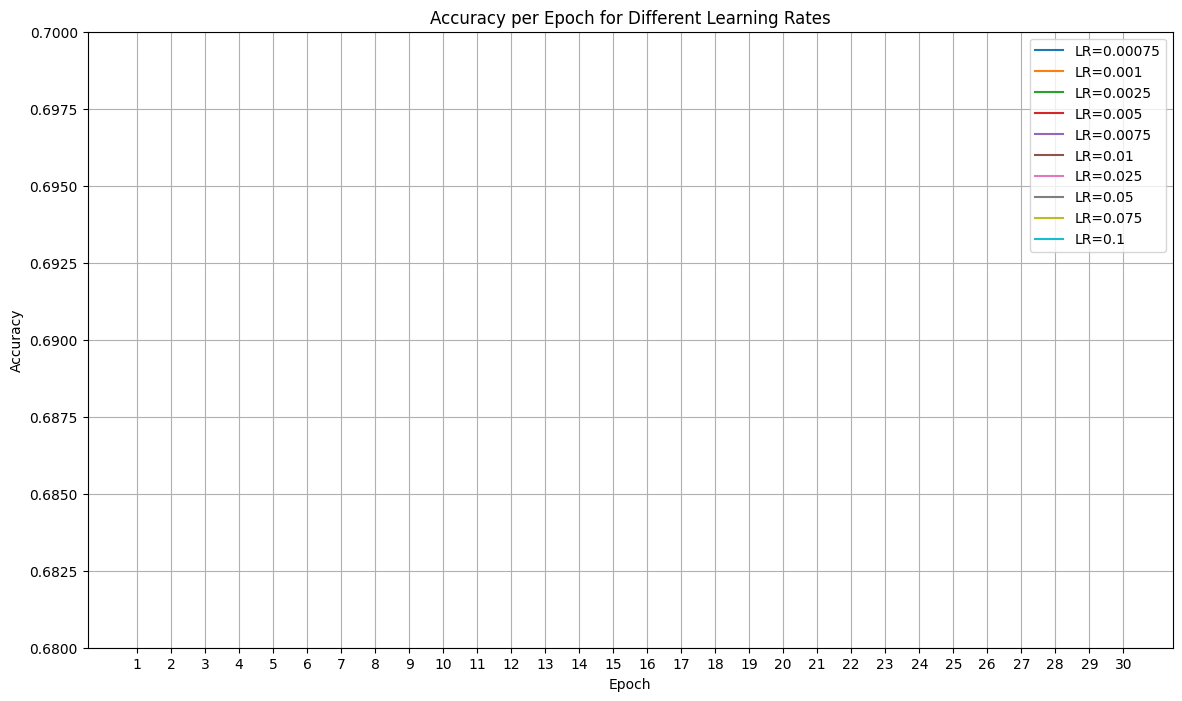

In [29]:
import mlflow
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Zielvariablen für die Vorhersage erstellen
data['Target'] = (data['Close'] <= data['Previous_Close']).astype(int)

data_clean = data
data_clean.dropna(inplace=True)
data_clean.reset_index(drop=True, inplace=True)

# Auswahl und Skalierung der relevanten Features
selected_features = ['Close', 'RSI', 'EMA20', 'Bollinger_Middle', 'MACD', 'Previous_Close']
sc = MinMaxScaler(feature_range=(0, 1))
scaled_features = sc.fit_transform(data[selected_features])

def create_sequences(features, target, seq_length):
    sequences = []
    labels = []
    for i in range(len(features) - seq_length):
        sequence = features[i:i + seq_length]
        label = target[i + seq_length]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Hyperparameter-Definition
learning_rates = [0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025, 0.001, 0.00075]
SEQ_LENGTH = 30  # Konstante Sequenzlänge
EPOCHS = 30
BATCH_SIZE = 32

# Setzen des MLflow Tracking URI und Anlegen eines neuen Experiments
mlflow.set_tracking_uri("http://127.0.0.1:8080")
mlflow.set_experiment("Bitcoin Price Movement Prediction CNN LSTM Learning Rate")

for lr in learning_rates:
    with mlflow.start_run():
        params = {
            "learning_rate": lr,
            "epochs": EPOCHS,
            "batch_size": BATCH_SIZE,
            "seq_length": SEQ_LENGTH
        }
        mlflow.log_params(params)

        # Daten vorbereiten basierend auf der aktuellen seq_length
        X, y = create_sequences(scaled_features, data['Target'].values, SEQ_LENGTH)

        # Datenaufteilung: 70% Training, 20% Validierung, 10% Test
        train_size = int(0.7 * len(X))
        val_size = int(0.2 * len(X))
        test_size = len(X) - train_size - val_size

        X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
        y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

        # Umformung der Daten für CNN-LSTM
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
        X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

        optimizer = Adam(learning_rate=lr)

        # Modellarchitektur definieren
        model = Sequential()
        # Hinzufügen von CNN-Schichten
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(SEQ_LENGTH, len(selected_features))))
        model.add(MaxPooling1D(pool_size=2))
        # Hinzufügen von LSTM-Schichten
        model.add(LSTM(units=50, activation='relu', return_sequences=True))
        model.add(LSTM(units=50, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(units=1, activation='sigmoid'))

        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        # Callback to log metrics at the end of each epoch
        class MlflowLogger(tf.keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs=None):
                mlflow.log_metric(f"loss_epoch_{epoch}", logs["loss"])
                mlflow.log_metric(f"val_loss_epoch_{epoch}", logs["val_loss"])
                mlflow.log_metric(f"accuracy_epoch_{epoch}", logs["accuracy"])
                mlflow.log_metric(f"val_accuracy_epoch_{epoch}", logs["val_accuracy"])

        # Modell trainieren und Verlaufsdaten speichern
        history = model.fit(
            X_train, y_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_data=(X_val, y_val),
            callbacks=[MlflowLogger()]
        )

        # Modell bewerten
        loss, accuracy = model.evaluate(X_test, y_test)
        print(f'Test Loss: {loss}')
        print(f'Test Accuracy: {accuracy}')

        # MLflow-Logging
        mlflow.log_metric("loss", loss)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.keras.log_model(model, "model")

# Extrahiere die Ergebnisse und plotte Learning Rate vs. Accuracy
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name("Bitcoin Price Movement Prediction CNN LSTM Learning Rate")
runs = client.search_runs(experiment_ids=[experiment.experiment_id])

all_history = {}

for run in runs:
    learning_rate = float(run.data.params['learning_rate'])
    accuracy_history = [run.data.metrics[f'accuracy_epoch_{epoch}'] for epoch in range(EPOCHS)]
    all_history[learning_rate] = accuracy_history

# Plotten des Verlaufs der Genauigkeit für jede Lernrate
plt.figure(figsize=(14, 8))

for lr, accuracy_history in all_history.items():
    plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, label=f'LR={lr}')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch for Different Learning Rates')
plt.ylim(0.68, 0.7)  # Setze den Bereich der y-Achse von 0.68 bis 0.7
plt.xticks(np.arange(1, 31, 1))  # Setze die x-Achse von 1 bis 30
plt.legend()
plt.grid(True)
plt.show()


Learning Rate Loss Funktion

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5300 - loss: 127.4955 - val_accuracy: 0.4877 - val_loss: 0.7107
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5311 - loss: 0.6900 - val_accuracy: 0.4877 - val_loss: 0.7140
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5548 - loss: 0.6907 - val_accuracy: 0.4877 - val_loss: 0.7048
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5377 - loss: 0.6904 - val_accuracy: 0.4877 - val_loss: 0.6934
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5391 - loss: 0.6902 - val_accuracy: 0.4877 - val_loss: 0.6962
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5444 - loss: 0.6896 - val_accuracy: 0.4877 - val_loss: 0.7021
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5376 - loss: 0.6926 - val_accuracy: 0.4877 - val_loss: 0.6938
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5418 - loss: 0.6927 - val_accuracy: 0.4877 - val_loss: 0.7055


2024/06/09 12:20:41 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6946921348571777
Test Accuracy: 0.5143678188323975
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5351 - loss: 109596.8672 - val_accuracy: 0.4877 - val_loss: 0.6965
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5587 - loss: 0.6885 - val_accuracy: 0.4877 - val_loss: 0.6939
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5532 - loss: 0.6908 - val_accuracy: 0.4877 - val_loss: 0.7030
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5377 - loss: 0.6916 - val_accuracy: 0.4877 - val_loss: 0.7097
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5423 - loss: 0.6921 - val_accuracy: 0.4877 - val_loss: 0.7075
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5505 - loss: 0.6888 - val_accuracy: 0.4877 - val_loss: 0.7050
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5509 - loss: 0.6881 - val_accuracy: 0.4877 - val_loss: 0.6964
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

2024/06/09 12:21:01 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6933221817016602
Test Accuracy: 0.5143678188323975
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5262 - loss: 4.6740 - val_accuracy: 0.4877 - val_loss: 0.7012
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5567 - loss: 0.6883 - val_accuracy: 0.4877 - val_loss: 0.6967
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5362 - loss: 0.6910 - val_accuracy: 0.4877 - val_loss: 0.7091
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5418 - loss: 0.6913 - val_accuracy: 0.4877 - val_loss: 0.6973
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5474 - loss: 0.6895 - val_accuracy: 0.4877 - val_loss: 0.7054
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5415 - loss: 0.6915 - val_accuracy: 0.4877 - val_loss: 0.6977
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5521 - loss: 0.6889 - val_accuracy: 0.4877 - val_loss: 0.6970
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - a

2024/06/09 12:21:21 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6927446722984314
Test Accuracy: 0.5143678188323975
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5330 - loss: 0.7046 - val_accuracy: 0.4877 - val_loss: 0.6977
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5504 - loss: 0.6885 - val_accuracy: 0.4877 - val_loss: 0.6970
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5380 - loss: 0.6905 - val_accuracy: 0.4877 - val_loss: 0.6998
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5485 - loss: 0.6888 - val_accuracy: 0.4877 - val_loss: 0.6979
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5539 - loss: 0.6879 - val_accuracy: 0.4877 - val_loss: 0.6961
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5425 - loss: 0.6894 - val_accuracy: 0.4877 - val_loss: 0.6971
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5435 - loss: 0.6899 - val_accuracy: 0.4877 - val_loss: 0.6970
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - ac

2024/06/09 12:21:40 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6930931210517883
Test Accuracy: 0.5143678188323975
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5325 - loss: 0.6922 - val_accuracy: 0.4877 - val_loss: 0.6959
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5514 - loss: 0.6889 - val_accuracy: 0.4877 - val_loss: 0.6990
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5353 - loss: 0.6910 - val_accuracy: 0.4877 - val_loss: 0.7019
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5462 - loss: 0.6895 - val_accuracy: 0.4877 - val_loss: 0.6990
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5423 - loss: 0.6898 - val_accuracy: 0.4877 - val_loss: 0.6994
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5442 - loss: 0.6894 - val_accuracy: 0.4877 - val_loss: 0.7001
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5550 - loss: 0.6874 - val_accuracy: 0.4877 - val_loss: 0.6984
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - ac

2024/06/09 12:22:00 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6952151656150818
Test Accuracy: 0.5143678188323975
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5381 - loss: 0.6909 - val_accuracy: 0.4877 - val_loss: 0.6980
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5369 - loss: 0.6908 - val_accuracy: 0.4877 - val_loss: 0.6999
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5498 - loss: 0.6890 - val_accuracy: 0.4877 - val_loss: 0.6976
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5464 - loss: 0.6885 - val_accuracy: 0.4877 - val_loss: 0.6945
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5369 - loss: 0.6905 - val_accuracy: 0.4877 - val_loss: 0.7008
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5480 - loss: 0.6891 - val_accuracy: 0.4877 - val_loss: 0.6976
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5493 - loss: 0.6884 - val_accuracy: 0.4877 - val_loss: 0.6967
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - ac

2024/06/09 12:22:21 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5096 - loss: 0.6928 - val_accuracy: 0.4877 - val_loss: 0.7010
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5397 - loss: 0.6904 - val_accuracy: 0.4877 - val_loss: 0.6982
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5430 - loss: 0.6896 - val_accuracy: 0.4877 - val_loss: 0.6981
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5445 - loss: 0.6888 - val_accuracy: 0.4877 - val_loss: 0.6987
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5202 - loss: 0.6936 - val_accuracy: 0.4877 - val_loss: 0.7003
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5526 - loss: 0.6864 - val_accuracy: 0.4877 - val_loss: 0.6964
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5605 - loss: 0.6866 - val_accuracy: 0.4877 - val_loss: 0.6986
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5294 - loss: 0.6918 - val_accuracy: 0.4877 - val_loss:

2024/06/09 12:22:42 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6930498480796814
Test Accuracy: 0.5143678188323975
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5364 - loss: 0.6923 - val_accuracy: 0.4877 - val_loss: 0.6962
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5483 - loss: 0.6888 - val_accuracy: 0.4877 - val_loss: 0.7084
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5399 - loss: 0.6953 - val_accuracy: 0.4877 - val_loss: 0.6961
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5303 - loss: 0.6911 - val_accuracy: 0.4877 - val_loss: 0.6971
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5431 - loss: 0.6890 - val_accuracy: 0.4877 - val_loss: 0.6966
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5601 - loss: 0.6848 - val_accuracy: 0.4877 - val_loss: 0.6945
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5448 - loss: 0.6883 - val_accuracy: 0.4877 - val_loss: 0.6952
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - a

2024/06/09 12:23:03 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6927763223648071
Test Accuracy: 0.5143678188323975
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5334 - loss: 0.6911 - val_accuracy: 0.4877 - val_loss: 0.6959
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5533 - loss: 0.6883 - val_accuracy: 0.4863 - val_loss: 0.6941
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5410 - loss: 0.6883 - val_accuracy: 0.4877 - val_loss: 0.6940
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5471 - loss: 0.6877 - val_accuracy: 0.4863 - val_loss: 0.6956
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5507 - loss: 0.6886 - val_accuracy: 0.4834 - val_loss: 0.6945
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5496 - loss: 0.6876 - val_accuracy: 0.4863 - val_loss: 0.6944
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5508 - loss: 0.6884 - val_accuracy: 0.4834 - val_loss: 0.6944
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - a

2024/06/09 12:23:24 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.692609965801239
Test Accuracy: 0.5143678188323975
Epoch 1/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5452 - loss: 0.6912 - val_accuracy: 0.4877 - val_loss: 0.6966
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5543 - loss: 0.6865 - val_accuracy: 0.4834 - val_loss: 0.6935
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5393 - loss: 0.6887 - val_accuracy: 0.4993 - val_loss: 0.6942
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5547 - loss: 0.6875 - val_accuracy: 0.4877 - val_loss: 0.6953
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5479 - loss: 0.6878 - val_accuracy: 0.4877 - val_loss: 0.6941
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5521 - loss: 0.6863 - val_accuracy: 0.4906 - val_loss: 0.6942
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5459 - loss: 0.6893 - val_accuracy: 0.4949 - val_loss: 0.6945
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - ac

2024/06/09 12:23:46 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6928000450134277
Test Accuracy: 0.5201149582862854


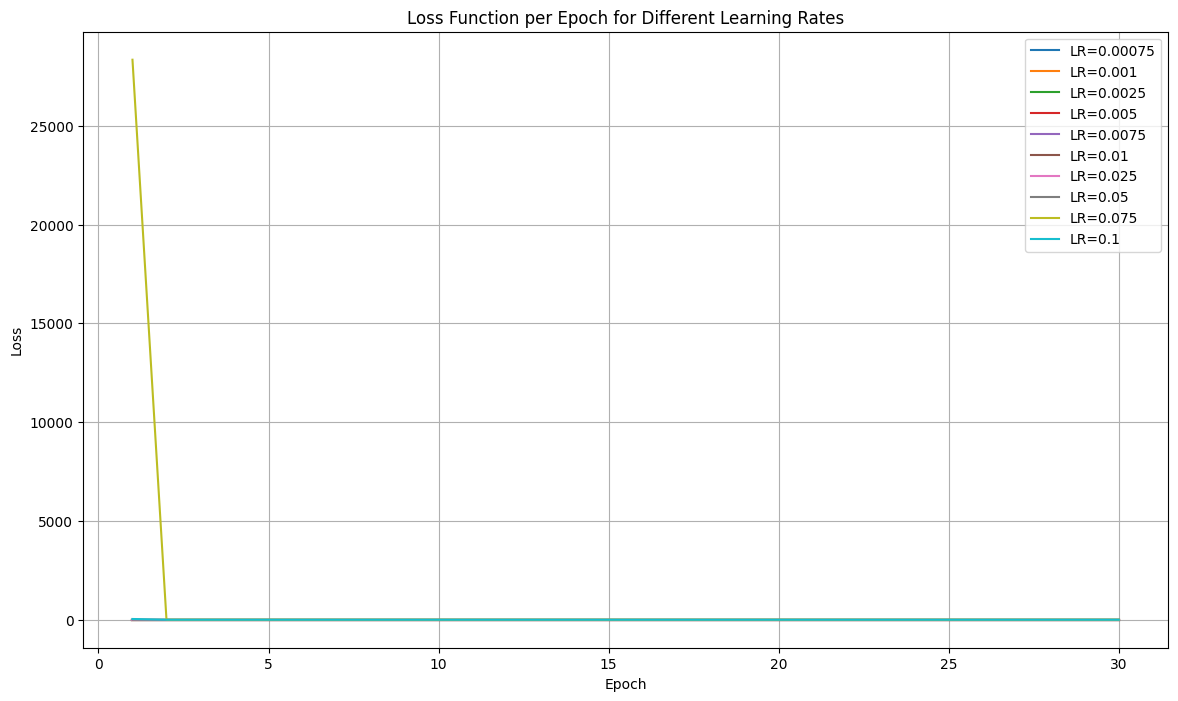

In [27]:
import mlflow
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

# Zielvariablen für die Vorhersage erstellen
data['Target'] = (data['Close'] <= data['Previous_Close']).astype(int)

data_clean = data
data_clean.dropna(inplace=True)
data_clean.reset_index(drop=True, inplace=True)

# Auswahl und Skalierung der relevanten Features
selected_features = ['Close', 'RSI', 'EMA20', 'Bollinger_Middle', 'MACD', 'Previous_Close']
sc = MinMaxScaler(feature_range=(0, 1))
scaled_features = sc.fit_transform(data[selected_features])

def create_sequences(features, target, seq_length):
    sequences = []
    labels = []
    for i in range(len(features) - seq_length):
        sequence = features[i:i + seq_length]
        label = target[i + seq_length]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Hyperparameter-Definition
learning_rates = [0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025, 0.001, 0.00075]
SEQ_LENGTH = 30  # Konstante Sequenzlänge
EPOCHS = 30
BATCH_SIZE = 32

# Setzen des MLflow Tracking URI und Anlegen eines neuen Experiments
mlflow.set_tracking_uri("http://127.0.0.1:8080")
mlflow.set_experiment("Bitcoin Price Movement Prediction CNN LSTM Learning Rate")

for lr in learning_rates:
    with mlflow.start_run():
        params = {
            "learning_rate": lr,
            "epochs": EPOCHS,
            "batch_size": BATCH_SIZE,
            "seq_length": SEQ_LENGTH
        }
        mlflow.log_params(params)

        # Daten vorbereiten basierend auf der aktuellen seq_length
        X, y = create_sequences(scaled_features, data['Target'].values, SEQ_LENGTH)

        # Datenaufteilung: 70% Training, 20% Validierung, 10% Test
        train_size = int(0.7 * len(X))
        val_size = int(0.2 * len(X))
        test_size = len(X) - train_size - val_size

        X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
        y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

        # Umformung der Daten für CNN-LSTM
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
        X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

        optimizer = Adam(learning_rate=lr)

        # Modellarchitektur definieren
        model = Sequential()
        # Hinzufügen von CNN-Schichten
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(SEQ_LENGTH, len(selected_features))))
        model.add(MaxPooling1D(pool_size=2))
        # Hinzufügen von LSTM-Schichten
        model.add(LSTM(units=50, activation='relu', return_sequences=True))
        model.add(LSTM(units=50, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(units=1, activation='sigmoid'))

        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        # Callback to log metrics at the end of each epoch
        class MlflowLogger(tf.keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs=None):
                mlflow.log_metric(f"loss_epoch_{epoch}", logs["loss"])
                mlflow.log_metric(f"val_loss_epoch_{epoch}", logs["val_loss"])

        # Modell trainieren und Verlaufsdaten speichern
        history = model.fit(
            X_train, y_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_data=(X_val, y_val),
            callbacks=[MlflowLogger()]
        )

        # Modell bewerten
        loss, accuracy = model.evaluate(X_test, y_test)
        print(f'Test Loss: {loss}')
        print(f'Test Accuracy: {accuracy}')

        # MLflow-Logging
        mlflow.log_metric("loss", loss)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.keras.log_model(model, "model")

# Extrahiere die Ergebnisse und plotte Learning Rate vs. Loss
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name("Bitcoin Price Movement Prediction CNN LSTM Learning Rate")
runs = client.search_runs(experiment_ids=[experiment.experiment_id])

all_history = {}

for run in runs:
    learning_rate = float(run.data.params['learning_rate'])
    loss_history = [run.data.metrics[f'loss_epoch_{epoch}'] for epoch in range(EPOCHS)]
    all_history[learning_rate] = loss_history

# Plotten des Verlaufs der Verlustfunktion für jede Lernrate
plt.figure(figsize=(14, 8))

for lr, loss_history in all_history.items():
    plt.plot(range(1, len(loss_history) + 1), loss_history, label=f'LR={lr}')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Function per Epoch for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()


X_train shape: (2426, 30, 6)
X_val shape: (693, 30, 6)
X_test shape: (348, 30, 6)
Reshaped X_train shape: (2426, 30, 6)
Reshaped X_val shape: (693, 30, 6)
Reshaped X_test shape: (348, 30, 6)
Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4786 - loss: 10678.0635 - val_accuracy: 0.4906 - val_loss: 0.6968
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5562 - loss: 0.6919 - val_accuracy: 0.4877 - val_loss: 0.6965
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5503 - loss: 0.6890 - val_accuracy: 0.4877 - val_loss: 0.7057
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5616 - loss: 0.6868 - val_accuracy: 0.4877 - val_loss: 0.6947
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5254 - loss: 0.6903 - val_accuracy: 0.5123 - val_loss: 0.6930
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5589 - loss: 0.6897 - val_accuracy: 0.4949 - val_loss: 0.6933
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5328 - loss: 0.6905 - val_accuracy: 0.4877 - val_loss: 0.6948
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5510 - loss: 0.6887 - val_accuracy: 0.4993 - val_loss: 0.6935

2024/06/09 12:09:58 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Confusion Matrix
[[179   0]
 [169   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       179
           1       0.00      0.00      0.00       169

    accuracy                           0.51       348
   macro avg       0.26      0.50      0.34       348
weighted avg       0.26      0.51      0.35       348

X_train shape: (2426, 30, 6)
X_val shape: (693, 30, 6)
X_test shape: (348, 30, 6)
Reshaped X_train shape: (2426, 30, 6)
Reshaped X_val shape: (693, 30, 6)
Reshaped X_test shape: (348, 30, 6)
Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5129 - loss: 4286.3809 - val_accuracy: 0.4877 - val_loss: 0.6957
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5245 - loss: 0.6919 - val_accuracy: 0.4877 - val_loss: 0.7033
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5456 - loss: 0.6906 - val_accuracy: 0.4877 - val_loss: 0.6954
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5407 - loss: 0.6909 - val_accuracy: 0.4877 - val_loss: 0.7051
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5504 - loss: 0.6882 - val_accuracy: 0.4877 - val_loss: 0.7033
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5523 - loss: 0.6883 - val_accuracy: 0.4877 - val_loss: 0.6964
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5524 - loss: 0.6885 - val_accuracy: 0.5123 - val_loss: 0.6929
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5154 - loss: 0.6909 - val_accuracy: 0.5123 - val_loss: 0.6929


2024/06/09 12:10:17 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6983195543289185
Test Accuracy: 0.5143678188323975
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Confusion Matrix
[[179   0]
 [169   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       179
           1       0.00      0.00      0.00       169

    accuracy                           0.51       348
   macro avg       0.26      0.50      0.34       348
weighted avg       0.26      0.51      0.35       348

X_train shape: (2426, 30, 6)
X_val shape: (693, 30, 6)
X_test shape: (348, 30, 6)
Reshaped X_train shape: (2426, 30, 6)
Reshaped X_val shape: (693, 30, 6)
Reshaped X_test shape: (348, 30, 6)
Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5202 - loss: 10.3437 - val_accuracy: 0.4877 - val_loss: 0.6963
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5312 - loss: 0.6925 - val_accuracy: 0.4877 - val_loss: 0.7096
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5362 - loss: 0.6939 - val_accuracy: 0.4877 - val_loss: 0.7018
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5507 - loss: 0.6882 - val_accuracy: 0.4877 - val_loss: 0.7027
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5306 - loss: 0.6930 - val_accuracy: 0.4877 - val_loss: 0.7186
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5477 - loss: 0.6996 - val_accuracy: 0.4877 - val_loss: 0.7010
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5598 - loss: 0.6868 - val_accuracy: 0.4877 - val_loss: 0.6966
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5446 - loss: 0.6902 - val_accuracy: 0.4877 - val_loss: 0.6972
Ep

2024/06/09 12:10:34 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6939685344696045
Test Accuracy: 0.5143678188323975
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Confusion Matrix
[[179   0]
 [169   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       179
           1       0.00      0.00      0.00       169

    accuracy                           0.51       348
   macro avg       0.26      0.50      0.34       348
weighted avg       0.26      0.51      0.35       348

X_train shape: (2426, 30, 6)
X_val shape: (693, 30, 6)
X_test shape: (348, 30, 6)
Reshaped X_train shape: (2426, 30, 6)
Reshaped X_val shape: (693, 30, 6)
Reshaped X_test shape: (348, 30, 6)
Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5002 - loss: 0.7085 - val_accuracy: 0.4877 - val_loss: 0.7005
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5238 - loss: 0.6939 - val_accuracy: 0.4877 - val_loss: 0.7009
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5285 - loss: 0.6928 - val_accuracy: 0.4877 - val_loss: 0.7009
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5343 - loss: 0.6915 - val_accuracy: 0.4877 - val_loss: 0.6993
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5548 - loss: 0.6880 - val_accuracy: 0.4877 - val_loss: 0.6982
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5439 - loss: 0.6905 - val_accuracy: 0.4877 - val_loss: 0.6969
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5569 - loss: 0.6883 - val_accuracy: 0.4877 - val_loss: 0.7004
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5492 - loss: 0.6883 - val_accuracy: 0.4877 - val_loss: 0.7006
Epo

2024/06/09 12:10:52 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.694149911403656
Test Accuracy: 0.5143678188323975
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Confusion Matrix
[[179   0]
 [169   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       179
           1       0.00      0.00      0.00       169

    accuracy                           0.51       348
   macro avg       0.26      0.50      0.34       348
weighted avg       0.26      0.51      0.35       348

X_train shape: (2426, 30, 6)
X_val shape: (693, 30, 6)
X_test shape: (348, 30, 6)
Reshaped X_train shape: (2426, 30, 6)
Reshaped X_val shape: (693, 30, 6)
Reshaped X_test shape: (348, 30, 6)
Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5248 - loss: 0.6938 - val_accuracy: 0.4877 - val_loss: 0.6964
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5479 - loss: 0.6893 - val_accuracy: 0.4877 - val_loss: 0.6979
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5303 - loss: 0.6923 - val_accuracy: 0.4834 - val_loss: 1.5894
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5302 - loss: 0.7183 - val_accuracy: 0.4877 - val_loss: 0.7005
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5414 - loss: 0.6900 - val_accuracy: 0.4877 - val_loss: 0.6979
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5389 - loss: 0.6905 - val_accuracy: 0.4877 - val_loss: 0.6993
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5339 - loss: 0.6911 - val_accuracy: 0.4877 - val_loss: 0.7014
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5567 - loss: 0.6873 - val_accuracy: 0.4877 - val_loss: 0.6992
Epo

2024/06/09 12:11:11 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.693963348865509
Test Accuracy: 0.5143678188323975
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Confusion Matrix
[[179   0]
 [169   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       179
           1       0.00      0.00      0.00       169

    accuracy                           0.51       348
   macro avg       0.26      0.50      0.34       348
weighted avg       0.26      0.51      0.35       348

X_train shape: (2426, 30, 6)
X_val shape: (693, 30, 6)
X_test shape: (348, 30, 6)
Reshaped X_train shape: (2426, 30, 6)
Reshaped X_val shape: (693, 30, 6)
Reshaped X_test shape: (348, 30, 6)
Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5334 - loss: 0.6921 - val_accuracy: 0.4877 - val_loss: 0.6981
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5651 - loss: 0.6841 - val_accuracy: 0.4877 - val_loss: 0.6943
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5555 - loss: 0.6894 - val_accuracy: 0.4877 - val_loss: 0.6965
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5518 - loss: 0.6879 - val_accuracy: 0.4877 - val_loss: 0.6970
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5364 - loss: 0.6915 - val_accuracy: 0.4877 - val_loss: 0.6998
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5306 - loss: 0.6928 - val_accuracy: 0.4877 - val_loss: 0.6973
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5479 - loss: 0.6894 - val_accuracy: 0.4877 - val_loss: 0.6986
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5257 - loss: 0.6923 - val_accuracy: 0.4877 - val_loss: 0.6977
Epo

2024/06/09 12:11:29 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.693783700466156
Test Accuracy: 0.5143678188323975
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Confusion Matrix
[[179   0]
 [169   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       179
           1       0.00      0.00      0.00       169

    accuracy                           0.51       348
   macro avg       0.26      0.50      0.34       348
weighted avg       0.26      0.51      0.35       348

X_train shape: (2426, 30, 6)
X_val shape: (693, 30, 6)
X_test shape: (348, 30, 6)
Reshaped X_train shape: (2426, 30, 6)
Reshaped X_val shape: (693, 30, 6)
Reshaped X_test shape: (348, 30, 6)
Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5621 - loss: 0.6882 - val_accuracy: 0.4877 - val_loss: 0.6956
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5483 - loss: 0.6881 - val_accuracy: 0.4877 - val_loss: 0.6986
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5487 - loss: 0.6893 - val_accuracy: 0.4877 - val_loss: 0.7001
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5475 - loss: 0.6885 - val_accuracy: 0.4877 - val_loss: 0.6974
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5369 - loss: 0.6907 - val_accuracy: 0.4877 - val_loss: 0.6981
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5384 - loss: 0.6898 - val_accuracy: 0.4877 - val_loss: 0.6965
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5608 - loss: 0.6856 - val_accuracy: 0.4877 - val_loss: 0.6949
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5519 - loss: 0.6864 - val_accuracy: 0.4877 - val_loss: 0.6956
Epo

2024/06/09 12:11:47 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6928344964981079
Test Accuracy: 0.5143678188323975
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Confusion Matrix
[[179   0]
 [169   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       179
           1       0.00      0.00      0.00       169

    accuracy                           0.51       348
   macro avg       0.26      0.50      0.34       348
weighted avg       0.26      0.51      0.35       348

X_train shape: (2426, 30, 6)
X_val shape: (693, 30, 6)
X_test shape: (348, 30, 6)
Reshaped X_train shape: (2426, 30, 6)
Reshaped X_val shape: (693, 30, 6)
Reshaped X_test shape: (348, 30, 6)
Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5252 - loss: 0.6906 - val_accuracy: 0.4877 - val_loss: 0.6966
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5359 - loss: 0.6896 - val_accuracy: 0.4877 - val_loss: 0.6997
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5416 - loss: 0.6906 - val_accuracy: 0.4877 - val_loss: 0.6969
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5328 - loss: 0.6900 - val_accuracy: 0.4877 - val_loss: 0.6977
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5423 - loss: 0.6899 - val_accuracy: 0.4877 - val_loss: 0.6949
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5487 - loss: 0.6884 - val_accuracy: 0.4906 - val_loss: 0.6949
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5539 - loss: 0.6879 - val_accuracy: 0.4877 - val_loss: 0.6944
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5410 - loss: 0.6881 - val_accuracy: 0.4877 - val_loss: 0.6960
Ep

2024/06/09 12:12:06 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6930411458015442
Test Accuracy: 0.49425286054611206
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Confusion Matrix
[[124  55]
 [121  48]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      0.69      0.58       179
           1       0.47      0.28      0.35       169

    accuracy                           0.49       348
   macro avg       0.49      0.49      0.47       348
weighted avg       0.49      0.49      0.47       348

X_train shape: (2426, 30, 6)
X_val shape: (693, 30, 6)
X_test shape: (348, 30, 6)
Reshaped X_train shape: (2426, 30, 6)
Reshaped X_val shape: (693, 30, 6)
Reshaped X_test shape: (348, 30, 6)
Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4962 - loss: 0.6927 - val_accuracy: 0.4877 - val_loss: 0.6969
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5497 - loss: 0.6876 - val_accuracy: 0.4906 - val_loss: 0.6937
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5555 - loss: 0.6876 - val_accuracy: 0.4877 - val_loss: 0.6957
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5189 - loss: 0.6954 - val_accuracy: 0.4877 - val_loss: 0.6952
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5483 - loss: 0.6873 - val_accuracy: 0.4877 - val_loss: 0.6955
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5703 - loss: 0.6836 - val_accuracy: 0.4791 - val_loss: 0.6937
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5243 - loss: 0.6903 - val_accuracy: 0.4877 - val_loss: 0.6951
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5636 - loss: 0.6856 - val_accuracy: 0.4921 - val_loss: 0.6947
Epo

2024/06/09 12:12:25 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6924943327903748
Test Accuracy: 0.517241358757019
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Confusion Matrix
[[157  22]
 [146  23]]
Classification Report
              precision    recall  f1-score   support

           0       0.52      0.88      0.65       179
           1       0.51      0.14      0.21       169

    accuracy                           0.52       348
   macro avg       0.51      0.51      0.43       348
weighted avg       0.51      0.52      0.44       348

X_train shape: (2426, 30, 6)
X_val shape: (693, 30, 6)
X_test shape: (348, 30, 6)
Reshaped X_train shape: (2426, 30, 6)
Reshaped X_val shape: (693, 30, 6)
Reshaped X_test shape: (348, 30, 6)
Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5368 - loss: 0.6906 - val_accuracy: 0.4877 - val_loss: 0.6946
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5448 - loss: 0.6885 - val_accuracy: 0.4877 - val_loss: 0.6945
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5574 - loss: 0.6847 - val_accuracy: 0.4877 - val_loss: 0.6944
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5566 - loss: 0.6870 - val_accuracy: 0.4877 - val_loss: 0.6938
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5371 - loss: 0.6896 - val_accuracy: 0.4877 - val_loss: 0.6950
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5464 - loss: 0.6862 - val_accuracy: 0.4877 - val_loss: 0.6948
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5472 - loss: 0.6877 - val_accuracy: 0.4877 - val_loss: 0.6953
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5478 - loss: 0.6876 - val_accuracy: 0.4877 - val_loss: 0.6943
Epo

2024/06/09 12:12:44 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6933080554008484
Test Accuracy: 0.48563218116760254
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Confusion Matrix
[[110  69]
 [110  59]]
Classification Report
              precision    recall  f1-score   support

           0       0.50      0.61      0.55       179
           1       0.46      0.35      0.40       169

    accuracy                           0.49       348
   macro avg       0.48      0.48      0.47       348
weighted avg       0.48      0.49      0.48       348



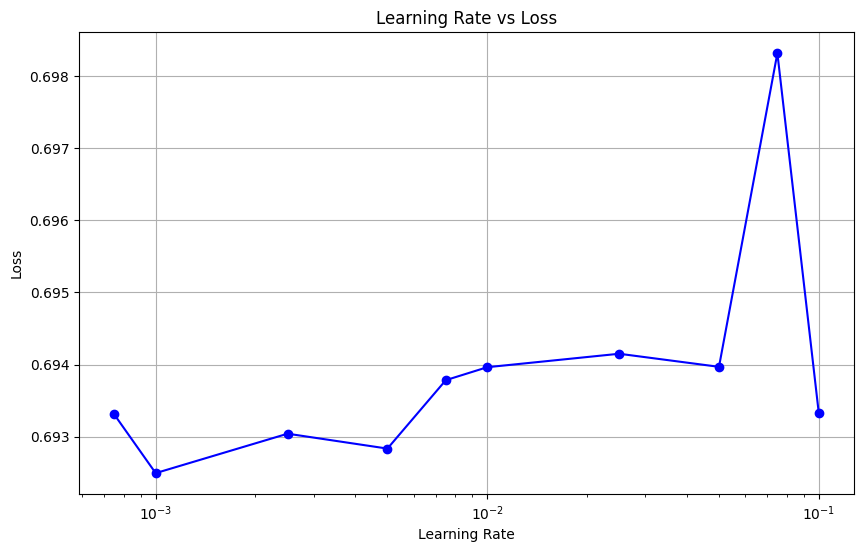

In [26]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")
mlflow.set_experiment("Bitcoin Price Movement Prediction CNN LSTM Learning Rate")

import mlflow
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
import itertools

# Zielvariablen für die Vorhersage erstellen
data['Target'] = (data['Close'] <= data['Previous_Close']).astype(int)

data_clean = data
data_clean.dropna(inplace=True)
data_clean.reset_index(drop=True, inplace=True)

# Auswahl und Skalierung der relevanten Features
selected_features = ['Close', 'RSI', 'EMA20', 'Bollinger_Middle', 'MACD', 'Previous_Close']
sc = MinMaxScaler(feature_range=(0, 1))
scaled_features = sc.fit_transform(data[selected_features])

def create_sequences(features, target, seq_length):
    sequences = []
    labels = []
    for i in range(len(features) - seq_length):
        sequence = features[i:i + seq_length]
        label = target[i + seq_length]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Hyperparameter-Definition
learning_rates = [0.1, 0.075, 0.05, 0.025, 0.01, 0.0075, 0.005, 0.0025, 0.001, 0.00075]
SEQ_LENGTH = 30  # Konstante Sequenzlänge
EPOCHS = 30
BATCH_SIZE = 32

# Setzen des MLflow Tracking URI und Anlegen eines neuen Experiments
mlflow.set_tracking_uri("http://127.0.0.1:8080")
mlflow.set_experiment("Bitcoin Price Movement Prediction CNN LSTM Learning Rate")

for lr in learning_rates:
    with mlflow.start_run():
        params = {
            "learning_rate": lr,
            "epochs": EPOCHS,
            "batch_size": BATCH_SIZE,
            "seq_length": SEQ_LENGTH
        }
        mlflow.log_params(params)

        # Daten vorbereiten basierend auf der aktuellen seq_length
        X, y = create_sequences(scaled_features, data['Target'].values, SEQ_LENGTH)

        # Datenaufteilung: 70% Training, 20% Validierung, 10% Test
        train_size = int(0.7 * len(X))
        val_size = int(0.2 * len(X))
        test_size = len(X) - train_size - val_size

        X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
        y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

        # Überprüfen der Formen der Daten
        print(f"X_train shape: {X_train.shape}")
        print(f"X_val shape: {X_val.shape}")
        print(f"X_test shape: {X_test.shape}")
        
        # Umformung der Daten für CNN-LSTM
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
        X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

        # Überprüfen der Formen der Daten nach Umformung
        print(f"Reshaped X_train shape: {X_train.shape}")
        print(f"Reshaped X_val shape: {X_val.shape}")
        print(f"Reshaped X_test shape: {X_test.shape}")

        optimizer = Adam(learning_rate=lr)

        # Modellarchitektur definieren
        model = Sequential()
        # Hinzufügen von CNN-Schichten
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(SEQ_LENGTH, len(selected_features))))
        model.add(MaxPooling1D(pool_size=2))
        # Hinzufügen von LSTM-Schichten
        model.add(LSTM(units=50, activation='relu', return_sequences=True))
        model.add(LSTM(units=50, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(units=1, activation='sigmoid'))

        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        # Modell trainieren
        history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

        # Modell bewerten
        loss, accuracy = model.evaluate(X_test, y_test)
        print(f'Test Loss: {loss}')
        print(f'Test Accuracy: {accuracy}')

        # MLflow-Logging
        mlflow.log_metric("loss", loss)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.keras.log_model(model, "model")

        # Vorhersagen treffen und Wahrscheinlichkeiten in binäre Werte umwandeln
        predictions = (model.predict(X_test) > 0.5).astype(int)

        # Confusion Matrix
        cm = confusion_matrix(y_test, predictions)
        print('Confusion Matrix')
        print(cm)

        # Classification Report
        cr = classification_report(y_test, predictions)
        print('Classification Report')
        print(cr)

        # Log confusion matrix and classification report
        with open("confusion_matrix_lstm.txt", "w") as f:
            f.write(str(cm))
        mlflow.log_artifact("confusion_matrix_lstm.txt")

        with open("classification_report_lstm.txt", "w") as f:
            f.write(cr)
        mlflow.log_artifact("classification_report_lstm.txt")

        # Set a tag for the run
        mlflow.set_tag("model", "CNN-LSTM")

# Extrahiere die Ergebnisse und plotte Learning Rate vs. Loss
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name("Bitcoin Price Movement Prediction CNN LSTM Learning Rate")
runs = client.search_runs(experiment_ids=[experiment.experiment_id])

learning_rates = []
losses = []

for run in runs:
    learning_rate = run.data.params['learning_rate']
    loss = run.data.metrics['loss']
    learning_rates.append(float(learning_rate))
    losses.append(float(loss))

# Plot the Learning Rate vs Loss
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, losses, marker='o', linestyle='-', color='b')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate vs Loss')
plt.grid(True)
plt.show()


Hyperparameter-Definition und Modelltraining

In [ ]:
# Vorhersagen treffen
predictions = (model.predict(X_test) > 0.5).astype(int)

# Modell bewerten
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')



In [ ]:
# Modell bewerten
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# MLflow-Logging
mlflow.log_metric("loss", loss)
mlflow.log_metric("accuracy", accuracy)
mlflow.keras.log_model(model, "model")


In [ ]:
# Ergebnisse visualisieren
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
print('Confusion Matrix')
print(cm)

# Classification Report
cr = classification_report(y_test, predictions)
print('Classification Report')
print(cr)

# Plot der Ergebnisse
plt.figure(figsize=(14, 5))
plt.plot(y_test, color='blue', label='Actual')
plt.plot(predictions, color='red', label='Predicted')
plt.title('Bitcoin Price Movement Prediction')
plt.xlabel('Time')
plt.ylabel('Class')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
print('Confusion Matrix')
print(cm)

# Classification Report
cr = classification_report(y_test, predictions)
print('Classification Report')
print(cr)

# Plot der Ergebnisse
plt.figure(figsize=(14, 5))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', marker='o')
plt.scatter(range(len(predictions)), predictions, color='red', label='Predicted', marker='x')
plt.title('Bitcoin Price Movement Prediction')
plt.xlabel('Time')
plt.ylabel('Class')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred_prob = model.predict(X_test).ravel()
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_pred_prob = model.predict(X_test).ravel()
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

plt.figure()
plt.step(recall, precision, where='post', label='Average precision score: AP={0:0.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


In [ ]:
y_pred_prob = model.predict(X_test).ravel()

plt.figure(figsize=(10, 5))
plt.hist(y_pred_prob, bins=50, edgecolor='k', alpha=0.7)
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()


Optimierungsmöglichkeiten für wenn Lifecycle Management Tool eingeführt ist:

Wenn Sie die Preisbewegung (zum Beispiel die Richtung der Preisänderung oder die prozentuale Änderung) anstelle des tatsächlichen Preises vorhersagen und feststellen, dass die Leistung des Modells nicht zufriedenstellend ist, gibt es mehrere Ansätze, um die Vorhersagequalität zu verbessern. Hier sind einige Strategien, die Sie in Betracht ziehen können:


### 2. **Modellarchitektur anpassen**
- **Anzahl der LSTM-Einheiten ändern**: Erhöhen oder verringern Sie die Anzahl der Neuronen in den LSTM-Schichten, um zu sehen, ob dies die Modellleistung beeinflusst.
- **Tiefe des Netzwerks**: Fügen Sie mehrere LSTM-Schichten hinzu, um ein tieferes Netzwerk zu erstellen, das möglicherweise komplexere Muster erfassen kann.
- **Dropout hinzufügen**: Um Overfitting zu vermeiden, fügen Sie Dropout-Schichten hinzu, die helfen können, die Generalisierbarkeit des Modells zu verbessern.

### 3. **Hyperparameter optimieren**
- **Lernrate anpassen**: Experimentieren Sie mit unterschiedlichen Lernraten und anderen Optimierungsparametern.
- **Batch-Größe und Epochenzahl**: Das Ändern der Batch-Größe und der Anzahl der Epochen kann erhebliche Auswirkungen auf das Trainingsergebnis haben.
- **Regularisierung anwenden**: Experimentieren Sie mit verschiedenen Arten von Regularisierungen (L1, L2), um das Overfitting zu kontrollieren.

### 4. **Verlustfunktion anpassen**
- **Andere Verlustfunktionen ausprobieren**: Wenn Sie die Richtung der Preisbewegung vorhersagen, könnte eine binäre Kreuzentropie (wenn es sich um eine Klassifikationsaufgabe handelt) oder eine benutzerdefinierte Verlustfunktion, die speziell für Ihr Vorhersageziel entwickelt wurde, nützlich sein.

### 5. **Trainingstechniken überprüfen**
- **Frühzeitiges Beenden**: Verwenden Sie Early Stopping, um das Training zu beenden, wenn sich die Validierungsleistung nicht mehr verbessert.
- **Daten-Shuffling und -Partitionierung**: Stellen Sie sicher, dass Ihre Trainings-, Validierungs- und Testdatensätze richtig partitioniert und während des Trainings effektiv gemischt werden.

### 6. **Evaluation und Benchmarking**
- **Cross-Validation verwenden**: Statt einer einfachen Train-Test-Split kann Cross-Validation eine robustere Evaluation der Modellleistung bieten.
- **Leistungsmetriken**: Überprüfen Sie, ob Sie die richtigen Metriken für die Bewertung des Modells verwenden. Für Klassifikationsaufgaben sind Genauigkeit, F1-Score, ROC-AUC usw. relevant.

Diese Ansätze bieten verschiedene Wege, die Modellleistung zu verbessern und sollten je nach spezifischem Szenario und den Ergebnissen der initialen Modellbewertungen angepasst werden.

**Visualisierung**

In [ ]:
import matplotlib.pyplot as plt

data = pd.read_csv("C:\WWI2021\Semester 6\Machine Learning Project\LSTM_BTC\data\BTC-USD.csv")


data['Previous_Close'] = data['Close'].shift(1)
data.dropna(inplace=True)

# Zielvariablen für die Visualisierung erstellen
data['Price_Change'] = data['Close'] - data['Previous_Close']
data['Price_Movement'] = data['Price_Change'].apply(lambda x: 'Steigen' if x > 0 else 'Fallen')

# Plot erstellen
plt.figure(figsize=(14, 7))
plt.plot(data['Date'], data['Price_Movement'].apply(lambda x: 1 if x == 'Steigen' else -1), marker='o', linestyle='-', color='b')
plt.yticks([1, -1], ['Steigen', 'Fallen'])
plt.title('Bitcoin Preisbewegung')
plt.xlabel('Datum')
plt.ylabel('Bewegung')
plt.grid(True)
plt.show()
